# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.core.display import Image, display

# Custom Libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

# Generate Data

First, let's generate some unlabelled data:


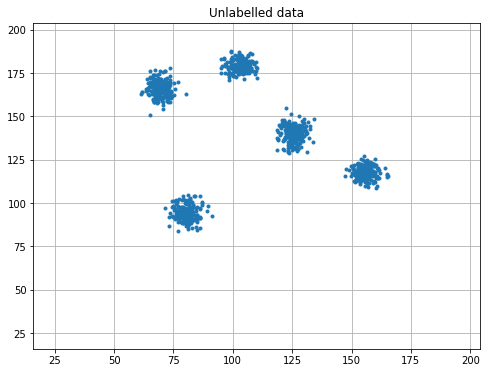

In [11]:
# Dataset 1: Random Points
dimensions = 2
nclusters = 5
covariance = 10
npoints = 200
minRange = 20
maxRange = 200

dataset = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                      labelled=False, random_flip=True, nonlinearities=False)

if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8,6)
    plot_data(dataset, "Unlabelled data", ax, labels=False, minrange=minRange, maxrange=maxRange, margin=4)
    plt.savefig("../Figures/unlabelled-data.pdf", bbox_inches='tight', pad_inches=0)

    plt.show()

In [8]:
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

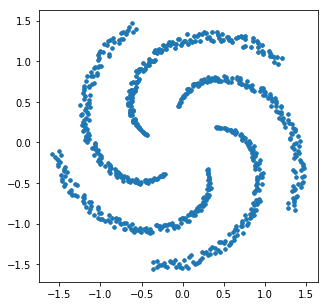

In [9]:
# Dataset 2: Fermat Spiral
n_points = 150
theta = np.linspace(np.pi/16,7*np.pi/9,n_points)
divergence = 0.05
a = np.random.uniform(1-divergence,1+divergence,n_points)

x = -a*np.sqrt(theta)*np.cos(theta)
y = a*np.sqrt(theta)*np.sin(theta)

n_spirals = 5
for i in range(1,5):
    x_, y_ = rotate([0,0],[x,y],i*2*np.pi/n_spirals)
    x = np.concatenate((x,x_))
    y = np.concatenate((y,y_))

fig = plt.figure(figsize=(5,5))
plt.scatter(x,y, marker='.')

# save as new dataset
dataset = np.asarray([x,y]).T
minRange = np.min(x)
maxRange = np.max(x)

#### Create single Density Tree

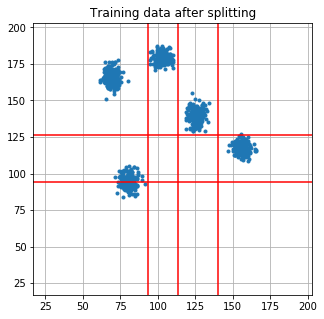

In [12]:
import warnings
warnings.filterwarnings("ignore")
root = create_density_tree(dataset, clusters=6)

def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals).astype(float)
cut_dims = np.asarray(cut_dims).astype(int)

# show splits
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

if dimensions == 2:
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    plot_data(dataset, "Training data after splitting", ax, labels=False, lines_x=x_split, lines_y=y_split,
              minrange=minRange, maxrange=maxRange, margin=3)

    %clear
    plt.show()

#### Showing all Clusters Covariances

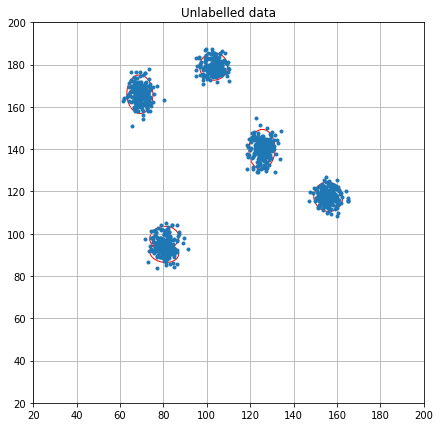

[0 1 1 0 0] [ 93.23597394 126.19437474  94.22475163 113.51829901 140.4397636 ]


In [16]:
covs, means = get_clusters(root, [], [])

if dimensions == 2:
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    fig.set_size_inches(7,7)
    plot_data(dataset, "Unlabelled data", ax, labels=False, n_clusters=nclusters, covs=covs, means=means,
              minrange = minRange, maxrange = maxRange, margin=0)
    plt.savefig("../Figures/unlabelled-data-cov.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    print(cut_dims, cut_vals)

# Printing the Tree

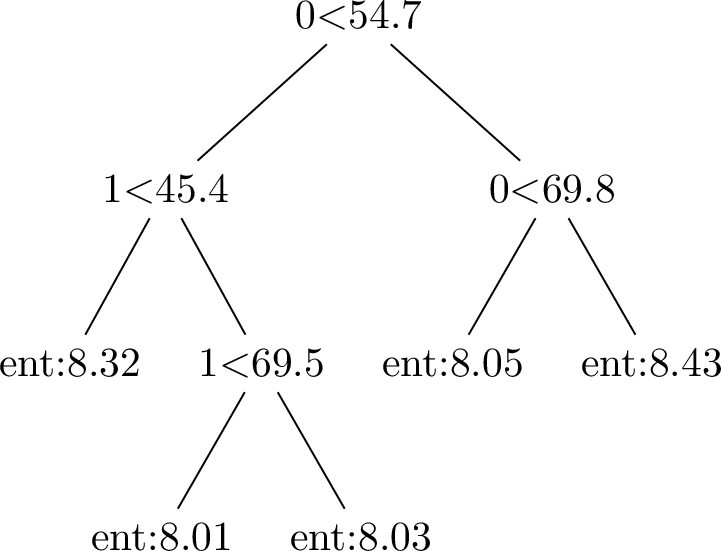

In [17]:
def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    
    os.system("cd ../Figures; rm main.tex; more main_pt1.tex >> density-tree.tex; echo '' >> density-tree.tex;")
    os.system("cd ../Figures; echo '" + tree_string + "' >> density-tree.tex;  more main_pt2.tex >> density-tree.tex;")
    os.system("cd ../Figures; /Library/TeX/texbin/pdflatex density-tree.tex; convert -density 300 -trim density-tree.pdf -quality 100 density-tree.png")
    os.system("cd ../Figures; rm *.aux *.log")
    display(Image('../Figures/density-tree.png', retina=True))
    
tree_visualize(root)

In [18]:
from scipy.stats import multivariate_normal

# loop
def create_plot_surface(minRange, maxRange, roots, n_points_dim=100, thresh=.1):
    grid = np.linspace(minRange, maxRange, n_points_dim)
    probas_out = np.zeros((n_points_dim,n_points_dim))

    for idx_x, pt in tqdm(enumerate(grid)):
        for idx_y, g in enumerate(grid):
            proba_pt=[]
            for root in roots:
                # descend tree
                d_mean, d_cov, d_pct = descend_density_tree([pt, g], root)
        
                # probability for this point to be from this distribution
                if d_pct > thresh:
                    proba_pt.append(multivariate_normal.pdf([pt, g], d_mean, d_cov)*d_pct)
                
            probas_out[idx_y, idx_x] = np.nanmean(proba_pt)

    fig = plt.figure(figsize=(7,7))
    plt.imshow(probas_out)


100it [00:01, 53.28it/s]


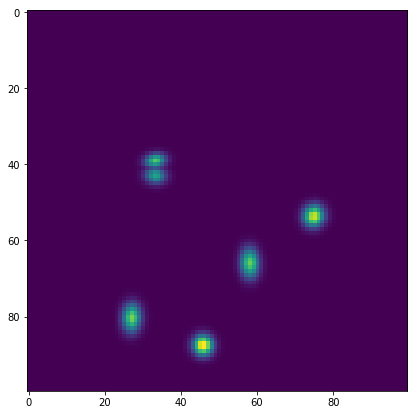

In [19]:
create_plot_surface(minRange, maxRange, [root], n_points_dim=100, thresh=0)

#### Descend tree (predict "label")

In [20]:
# for all points 
probas = []
probas_other = []
for d in dataset:
    # descend tree
    d_mean, d_cov, d_pct = descend_density_tree(d,root)

    # probability for this point to be from this distribution
    probas.append(multivariate_normal.pdf(d, d_mean, d_cov)*d_pct)
    for i in range(5):
        probas_other.append(multivariate_normal.pdf(d, means[i], covs[i])*d_pct)
    
print("Probability to come from the leaf node cluster: %.5f%%" % np.mean(probas))
print("Probability to come from an arbitrary cluster: %.5f%%" % np.mean(probas_other))

Probability to come from the leaf node cluster: 0.00123%
Probability to come from an arbitrary cluster: 0.00020%


#### Density Forest

In [30]:
root_nodes = density_forest_create(dataset, nclusters, 20, subsample_pct=.1, n_jobs=-1)

[Parallel(n_jobs=40)]: Done   4 out of  20 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=40)]: Done  20 out of  20 | elapsed:    0.2s finished


In [31]:
d_proba_mean = density_forest_traverse(dataset, root_nodes, thresh = .3)

100%|██████████| 1000/1000 [00:00<00:00, 22740.50it/s]


100it [00:22,  4.43it/s]


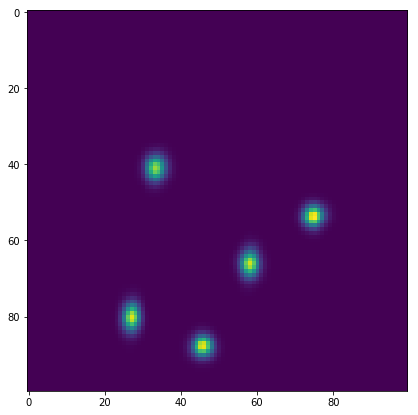

In [32]:
create_plot_surface(minRange, maxRange, root_nodes, n_points_dim=100, thresh=.1)